# 06 Time Series forecast with ElasticNet

the elastic net is a regularized regression method that linearly combines the L1 and L2 penalties of the lasso and ridge regularization methods to encourage simpler models that have smaller coefficient values.

I read the data after the preliminary EDA performed as part of the project proposal.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, QuantileTransformer

I read the training and the test set.

In [4]:
X_tr_valid = np.load('X_tr_imputed.npy')
y_tr_valid = np.load('y_tr.npy')

# X_valid = np.load('features_valid.npy')
# y_valid = np.load('labels_valid.npy')

X_test = np.load('X_te_imputed.npy')
y_test = np.load('y_te.npy')

In [5]:
df_tr = pd.read_pickle('training_dataset_df.csv')

I define the quantile transformation and the columns of the future matrix that it will be applied.

In [6]:
# qt_columns = ['SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'WSPM', 'PM10']
qt_columns = [6,7,8,9,10,11,12,15,16] # column indexes
qt = QuantileTransformer(n_quantiles = 1000, random_state = 0)

I apply the Quantile transformation of n = 1000 quantiles to the target vector. The Quantile-transformed target vector is y_tr_qt.

In [7]:
y_tr_valid_qt = qt.fit_transform(y_tr_valid.reshape(-1, 1))[:,0]
y_tr_valid_qt.shape

(30704,)

In [8]:
y_test_qt = qt.fit_transform(y_test.reshape(-1, 1))[:,0]

In [9]:
y_tr_valid.shape

(30704,)

In [10]:
y_tr_valid.reshape(-1, 1).shape

(30704, 1)

I define the error functions (more on the metrics later)

In [11]:
# Mean Absolute error (MAE)
def MAE(y,y_pred):    
    return(np.mean(np.abs(y-y_pred)))

def MSE(y, y_pred):
    return np.mean(np.square(y - y_pred))


# Invert log-transformation and compute model error  -- not nneeded if quantile transformation used for target vector
def model_error(y,y_pred):
    # score = MAE(np.exp(y),np.exp(y_pred)) # Invert log-transformation and compute MAE
    score = MAE(y, y_pred) # invert QuantileTransformation
    # y_test does not need to be transformed
    return score

def RSS(y,y_pred):
    # score = MAE(np.exp(y),np.exp(y_pred)) # Invert log-transformation and compute MAE 
    # score = RSS(y_test, qt.inverse_transform(y_pred)) # invert QuantileTransformation
    score = np.sum(np.square(y - y_pred))# invert QuantileTransformation
    # y_test does not need to be transformed
    return score


def R2_score(y,y_pred, y_train):
    score = 1-(RSS(y, y_pred)/RSS(y,y_train.mean()))
    return score      

the data training/valid and test data have One-Hot-Encoding for all the categorical features. I define my pipeline for the rest of the preprocessing and the model-fitting with the ElsticNet. I will scale the data before using the ElasticNet as regulairzation is used. Anyway it is a good practise to scale the features as the chances for the estimator to converge to a global minimum error (not a local one) are better with scaling. 

In [12]:
elastic_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('preprocessor', ColumnTransformer([('quantile', qt, qt_columns)], remainder='passthrough')),
    ('elastic', ElasticNet(random_state = 0, selection = 'random', normalize = False)) # Grid search needed
])

In [13]:
elastic_pipe.named_steps

{'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'preprocessor': ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
          transformer_weights=None,
          transformers=[('quantile', QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
           output_distribution='uniform', random_state=0, subsample=100000), [6, 7, 8, 9, 10, 11, 12, 15, 16])]),
 'elastic': ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
       max_iter=1000, normalize=False, positive=False, precompute=False,
       random_state=0, selection='random', tol=0.0001, warm_start=False)}

I define a grid for the hyperparameters I want to fine tune.

In [14]:
grid = { 'elastic__alpha' : np.arange(0.1,1.1,0.1),
         'elastic__l1_ratio' : np.arange(0,1.1,0.1)
         # 'knnreg__algorithm' : ['ball_tree', 'kd_tree', 'brute']
       }

With time series data we have to preserve the chronological order of observations because of their temporal dependency (autocorrelation). We cannot shuffle the data so we can only learn from the past and predict the future, not the other way around. That means that the training set will always precede the validation set. If we choose one validation set we do not know if it is representative of what we would observe in the future. Therefore k-fold cross-validation comes into play to reduce the bias of an ML model estimation of the prediction error. Moreover the final score will be the average of scores obtained in each fold. This reduces overfitting and constitutes a more robust way of model evaluation. I will use the TimeSeriesSplit to split the time series training set in rolling k = 4 folds.

In [15]:
tscv = TimeSeriesSplit(n_splits = 4)

In [16]:
tscv.split(X_tr_valid)
for train_index, valid_index in tscv.split(X_tr_valid, y_tr_valid_qt):
    print(train_index, valid_index)

[   0    1    2 ... 6141 6142 6143] [ 6144  6145  6146 ... 12281 12282 12283]
[    0     1     2 ... 12281 12282 12283] [12284 12285 12286 ... 18421 18422 18423]
[    0     1     2 ... 18421 18422 18423] [18424 18425 18426 ... 24561 24562 24563]
[    0     1     2 ... 24561 24562 24563] [24564 24565 24566 ... 30701 30702 30703]


In [17]:
tscv.get_n_splits()

4

In [18]:
for train_index, valid_index in tscv.split(X_tr_valid, y_tr_valid_qt):
    X_train, X_valid = X_tr_valid[train_index], X_tr_valid[valid_index]
    y_train, y_valid = y_tr_valid[train_index], y_tr_valid[valid_index]

After generating the k-folds I will use the GridSearchCV to do the grid search for hyperparameter tuning.

In [19]:
y_tr_valid.shape

(30704,)

By default the metric used is the determination coefficient but I want to use the negative mean absolute error (NMAE) and therefore I sill set the scoring parameter respectively. The - sign is added in the end to allow for the schikit convention "higher" is better.

In [20]:
grid_cv = GridSearchCV(elastic_pipe, grid, cv = tscv, return_train_score = True, verbose = 1, n_jobs = -1, scoring = 'neg_mean_absolute_error')

In [21]:
grid_cv.fit(X_tr_valid, y_tr_valid_qt)

Fitting 4 folds for each of 110 candidates, totalling 440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 440 out of 440 | elapsed:   47.2s finished
/Users/tgdstpej/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=4),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('preprocessor', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('quantile', QuantileTransformer(copy=True, ignore_implicit_zeros=Fals...e=False, precompute=False,
      random_state=0, selection='random', tol=0.0001, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'elastic__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), 'elastic__l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

In [22]:
grid_cv.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('preprocessor', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('quantile', QuantileTransformer(copy=True, ignore_implicit_zeros=Fals...e=False, precompute=False,
      random_state=0, selection='random', tol=0.0001, warm_start=False))])

In [23]:
grid_cv.cv_results_

{'mean_fit_time': array([3.98851848, 0.42200524, 0.36004525, 0.33763176, 0.33496565,
        0.33192986, 0.31948656, 0.34024823, 0.36001045, 0.3554706 ,
        0.3685928 , 4.09472078, 0.42488056, 0.37269795, 0.35948366,
        0.34290963, 0.33527535, 0.29836845, 0.30517673, 0.28098917,
        0.2653932 , 0.26671314, 3.8501085 , 0.36485761, 0.33251029,
        0.36030108, 0.32482618, 0.33121252, 0.27532792, 0.27958065,
        0.27687955, 0.26139373, 0.22720152, 3.73228675, 0.31578982,
        0.32120955, 0.30815881, 0.30240411, 0.33230281, 0.24836469,
        0.27169096, 0.24976474, 0.24066001, 0.23384035, 3.78269506,
        0.31782389, 0.30539471, 0.30192554, 0.276182  , 0.27539271,
        0.28707725, 0.29795498, 0.29098636, 0.262034  , 0.23702818,
        3.79615766, 0.3974877 , 0.32452244, 0.29100901, 0.25165147,
        0.25721622, 0.24053508, 0.23125851, 0.24787265, 0.27551574,
        0.24612528, 3.71131474, 0.30980939, 0.30195159, 0.33254379,
        0.3019495 , 0.282103  ,

In [24]:
grid_cv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_elastic__alpha', 'param_elastic__l1_ratio', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'mean_train_score', 'std_train_score'])

In [25]:
cv_results = pd.DataFrame(grid_cv.cv_results_)
cols = ['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'param_elastic__alpha', 'param_elastic__l1_ratio']
cv_results[cols].sort_values(by = 'mean_test_score', ascending = False).head()

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_elastic__alpha,param_elastic__l1_ratio
0,-0.098643,0.003599,-0.094741,0.001803,0.1,0
11,-0.106427,0.003758,-0.102627,0.002752,0.2,0
22,-0.111172,0.003852,-0.107532,0.003165,0.3,0
1,-0.114185,0.001578,-0.109143,0.002853,0.1,0.1
33,-0.114783,0.003947,-0.111271,0.003409,0.4,0


I will now turn the results to MAE.

In [24]:
cv_results = pd.DataFrame(grid_cv.cv_results_)
cols = ['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'param_elastic__alpha', 'param_elastic__l1_ratio']
cv_results['mean_test_score'] = np.abs(cv_results['mean_test_score'])
cv_results['mean_train_score'] = np.abs(cv_results['mean_train_score'])
cv_results[cols].sort_values(by = 'mean_test_score', ascending = True).head(10)

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_elastic__alpha,param_elastic__l1_ratio
0,0.098643,0.003599,0.094741,0.001803,0.1,0
11,0.106427,0.003758,0.102627,0.002752,0.2,0
22,0.111172,0.003852,0.107532,0.003165,0.3,0
1,0.114185,0.001578,0.109143,0.002853,0.1,0.1
33,0.114783,0.003947,0.111271,0.003409,0.4,0
44,0.117789,0.004046,0.114376,0.003587,0.5,0
55,0.120403,0.004165,0.117071,0.003720,0.6,0
66,0.122727,0.004296,0.119472,0.003826,0.7,0
77,0.124829,0.004435,0.121648,0.003916,0.8,0
88,0.126761,0.004572,0.123649,0.003998,0.9,0


In [25]:
cv_results.to_pickle('ElasticNet_cv.csv')
cv_results.head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_elastic__alpha,param_elastic__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,3.607587,1.792997,0.045110,0.005785,0.1,0,"{'elastic__alpha': 0.1, 'elastic__l1_ratio': 0.0}",-0.097112,-0.100214,-0.103469,-0.093775,0.098643,0.003599,1,-0.091760,-0.096611,-0.095334,-0.095258,0.094741,0.001803
1,0.498429,0.124062,0.048361,0.004465,0.1,0.1,"{'elastic__alpha': 0.1, 'elastic__l1_ratio': 0.1}",-0.112937,-0.116075,-0.115385,-0.112343,0.114185,0.001578,4,-0.104244,-0.111391,-0.110468,-0.110468,0.109143,0.002853
2,0.297516,0.103009,0.042074,0.007326,0.1,0.2,"{'elastic__alpha': 0.1, 'elastic__l1_ratio': 0.2}",-0.125223,-0.131577,-0.128619,-0.128375,0.128448,0.002248,11,-0.114689,-0.125592,-0.125951,-0.125481,0.122928,0.004760
3,0.280715,0.084340,0.041792,0.006057,0.1,0.3,"{'elastic__alpha': 0.1, 'elastic__l1_ratio': 0...",-0.126794,-0.137669,-0.133852,-0.135027,0.133336,0.004022,14,-0.117953,-0.131161,-0.131753,-0.132601,0.128367,0.006034


In [26]:
cv_results = pd.read_pickle('ElasticNet_cv.csv')
cv_results.head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_elastic__alpha,param_elastic__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,3.607587,1.792997,0.045110,0.005785,0.1,0,"{'elastic__alpha': 0.1, 'elastic__l1_ratio': 0.0}",-0.097112,-0.100214,-0.103469,-0.093775,0.098643,0.003599,1,-0.091760,-0.096611,-0.095334,-0.095258,0.094741,0.001803
1,0.498429,0.124062,0.048361,0.004465,0.1,0.1,"{'elastic__alpha': 0.1, 'elastic__l1_ratio': 0.1}",-0.112937,-0.116075,-0.115385,-0.112343,0.114185,0.001578,4,-0.104244,-0.111391,-0.110468,-0.110468,0.109143,0.002853
2,0.297516,0.103009,0.042074,0.007326,0.1,0.2,"{'elastic__alpha': 0.1, 'elastic__l1_ratio': 0.2}",-0.125223,-0.131577,-0.128619,-0.128375,0.128448,0.002248,11,-0.114689,-0.125592,-0.125951,-0.125481,0.122928,0.004760
3,0.280715,0.084340,0.041792,0.006057,0.1,0.3,"{'elastic__alpha': 0.1, 'elastic__l1_ratio': 0...",-0.126794,-0.137669,-0.133852,-0.135027,0.133336,0.004022,14,-0.117953,-0.131161,-0.131753,-0.132601,0.128367,0.006034


In [27]:
mean_train = cv_results['mean_train_score']
mean_test = cv_results['mean_test_score']
std_train = cv_results['std_train_score']
std_test = cv_results['std_test_score']
alphas = cv_results['param_elastic__alpha']
l1_ratios = cv_results['param_elastic__l1_ratio']

In [28]:
index = mean_test.idxmin()
best_alpha = cv_results['param_elastic__alpha'][index]
best_L1_ratio = cv_results['param_elastic__l1_ratio'][index]
best_L1_ratio

0.0

In [29]:
grid_cv.best_estimator_.steps

[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('preprocessor',
  ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
           transformer_weights=None,
           transformers=[('quantile', QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
            output_distribution='uniform', random_state=0, subsample=100000), [6, 7, 8, 9, 10, 11, 12, 15, 16])])),
 ('elastic',
  ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.0,
        max_iter=1000, normalize=False, positive=False, precompute=False,
        random_state=0, selection='random', tol=0.0001, warm_start=False))]

In [30]:
grid_cv.best_estimator_.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('preprocessor', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('quantile', QuantileTransformer(copy=True, ignore_implicit_zeros=Fals...e=False, precompute=False,
      random_state=0, selection='random', tol=0.0001, warm_start=False))])>

In [26]:
grid_cv.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('preprocessor',
   ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
            transformer_weights=None,
            transformers=[('quantile', QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
             output_distribution='uniform', random_state=0, subsample=100000), [6, 7, 8, 9, 10, 11, 12, 15, 16])])),
  ('elastic',
   ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.0,
         max_iter=1000, normalize=False, positive=False, precompute=False,
         random_state=0, selection='random', tol=0.0001, warm_start=False))],
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'preprocessor': ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
          transformer_weights=None,
          transformers=[('quantile', QuantileTransformer(copy=True, ignore_implicit_zero

In [31]:
scores = cv_results[['mean_test_score',  'std_test_score', 'mean_train_score', 'std_train_score','param_elastic__alpha', 'param_elastic__l1_ratio']]

In [32]:
scores.columns = ['MAE_test','std_test_score', 'MAE_train', 'std_train_score', 'alpha', 'L1_ratio']
scores.head()

,MAE_test,std_test_score,MAE_train,std_train_score,alpha,L1_ratio
0,0.098643,0.003599,0.094741,0.001803,0.1,0
1,0.114185,0.001578,0.109143,0.002853,0.1,0.1
2,0.128448,0.002248,0.122928,0.004760,0.1,0.2
3,0.133336,0.004022,0.128367,0.006034,0.1,0.3
4,0.136451,0.004231,0.131623,0.005699,0.1,0.4


In [33]:
scores_te = scores[['MAE_test', 'alpha', 'L1_ratio']]

In [34]:
#scores = np.array(scores).reshape(len(Cs), len(Gammas))

In [35]:
scores_te.head()

,MAE_test,alpha,L1_ratio
0,0.098643,0.1,0
1,0.114185,0.1,0.1
2,0.128448,0.1,0.2
3,0.133336,0.1,0.3
4,0.136451,0.1,0.4


In [36]:
scores_te.groupby(['alpha', 'L1_ratio']).size()

alpha  L1_ratio
0.1    0.0         1
       0.1         1
       0.2         1
       0.3         1
       0.4         1
       0.5         1
       0.6         1
       0.7         1
       0.8         1
       0.9         1
       1.0         1
0.2    0.0         1
       0.1         1
       0.2         1
       0.3         1
       0.4         1
       0.5         1
       0.6         1
       0.7         1
       0.8         1
       0.9         1
       1.0         1
0.3    0.0         1
       0.1         1
       0.2         1
       0.3         1
       0.4         1
       0.5         1
       0.6         1
       0.7         1
                  ..
0.8    0.3         1
       0.4         1
       0.5         1
       0.6         1
       0.7         1
       0.8         1
       0.9         1
       1.0         1
0.9    0.0         1
       0.1         1
       0.2         1
       0.3         1
       0.4         1
       0.5         1
       0.6         1
       0.7        

In [37]:
scores_grouped = scores_te.groupby(['alpha', 'L1_ratio']).mean().unstack(level = 1)

In [38]:
scores_grouped

MAE_test                                                    \
L1_ratio       0.0       0.1       0.2       0.3       0.4       0.5   
alpha                                                                  
0.1       0.098643  0.114185  0.128448  0.133336  0.136451  0.140036   
0.2       0.106427  0.131444  0.139626  0.147612  0.156164  0.165715   
0.3       0.111172  0.138959  0.150352  0.164287  0.179568  0.196203   
0.4       0.114783  0.144314  0.161941  0.182671  0.204761  0.229195   
0.5       0.117789  0.150090  0.174315  0.201432  0.230579  0.253576   
0.6       0.120403  0.156367  0.187078  0.220238  0.251921  0.253576   
0.7       0.122727  0.162918  0.199728  0.238561  0.253576  0.253576   
0.8       0.124829  0.169465  0.212241  0.252133  0.253576  0.253576   
0.9       0.126761  0.176034  0.224112  0.253576  0.253576  0.253576   
1.0       0.128553  0.182567  0.235279  0.253576  0.253576  0.253576   

                                                            
L1_ratio       0.6       0.7       0.8       0.9       1.0  
alpha                                                       
0.1       0.143528  0.147325  0.151333  0.155287  0.159470  
0.2       0.175702  0.186023  0.197301  0.210015  0.223414  
0.3       0.214229  0.233002  0.251452  0.253576  0.253576  
0.4       0.251635  0.253576  0.253576  0.253576  0.253576  
0.5       0.253576  0.253576  0.253576  0.253576  0.253576  
0.6       0.253576  0.253576  0.253576  0.253576  0.253576  
0.7       0.253576  0.253576  0.253576  0.253576  0.253576  
0.8       0.253576  0.253576  0.253576  0.253576  0.253576  
0.9       0.253576  0.253576  0.253576  0.253576  0.253576  
1.0       0.253576  0.253576  0.253576  0.253576  0.253576

I will now visualize my haperparameter grid search.

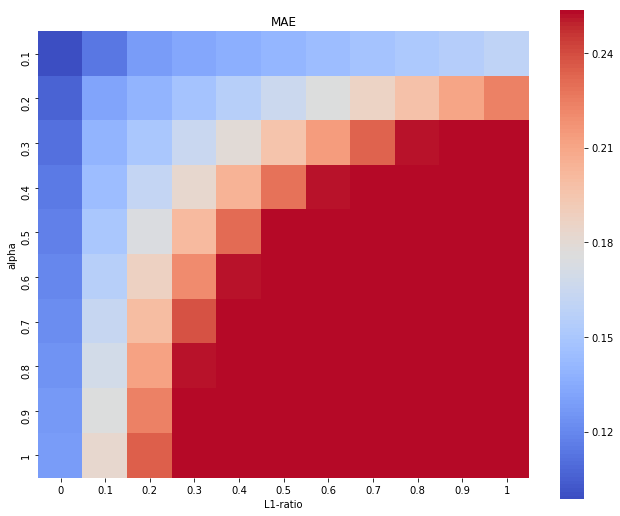

In [39]:
fig, ax = plt.subplots(figsize=(11, 9))
# plot heatmap
#sns.heatmap(months, cmap="Blues", vmin= 0.9, vmax=1.65,
#           linewidth=0.3, cbar_kws={"shrink": .8})
#xticklabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dec']
yticklabels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
xticklabels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# ax = sns.heatmap(pm2p5_g, annot=False, cmap="Blues", xticklabels = xticklabels)
# ax = sns.heatmap(pm2p5_g, annot=False, cmap="Blues", xticklabels = xticklabels)
# ax = sns.heatmap(scores_1, square = True, annot=False, cmap=sns.color_palette("coolwarm", 128))
#ax = sns.heatmap(scores_1, square = True, annot=False, cmap=sns.color_palette("coolwarm", 128), xticklabels = xticklabels)
ax = sns.heatmap(scores_grouped, square = True, annot=False, cmap=sns.color_palette("coolwarm", 128), xticklabels = xticklabels, yticklabels = yticklabels)

ax.set_title('MAE')
#ax.set(title = '{}'.format(feature))
plt.ylabel("alpha")
plt.xlabel("L1-ratio")
plt.show()

In [40]:
scores_by_L1_ratio = scores.groupby('L1_ratio')
scores_by_L1_ratio.size()

L1_ratio
0.0    10
0.1    10
0.2    10
0.3    10
0.4    10
0.5    10
0.6    10
0.7    10
0.8    10
0.9    10
1.0    10
dtype: int64

In [41]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
L1_ratios = [0, 0.2, 0.4, 0.6, 0.8, 1]

In [42]:
scores_by_L1_ratio.groups

{0.0: Int64Index([0, 11, 22, 33, 44, 55, 66, 77, 88, 99], dtype='int64'),
 0.1: Int64Index([1, 12, 23, 34, 45, 56, 67, 78, 89, 100], dtype='int64'),
 0.2: Int64Index([2, 13, 24, 35, 46, 57, 68, 79, 90, 101], dtype='int64'),
 0.30000000000000004: Int64Index([3, 14, 25, 36, 47, 58, 69, 80, 91, 102], dtype='int64'),
 0.4: Int64Index([4, 15, 26, 37, 48, 59, 70, 81, 92, 103], dtype='int64'),
 0.5: Int64Index([5, 16, 27, 38, 49, 60, 71, 82, 93, 104], dtype='int64'),
 0.6000000000000001: Int64Index([6, 17, 28, 39, 50, 61, 72, 83, 94, 105], dtype='int64'),
 0.7000000000000001: Int64Index([7, 18, 29, 40, 51, 62, 73, 84, 95, 106], dtype='int64'),
 0.8: Int64Index([8, 19, 30, 41, 52, 63, 74, 85, 96, 107], dtype='int64'),
 0.9: Int64Index([9, 20, 31, 42, 53, 64, 75, 86, 97, 108], dtype='int64'),
 1.0: Int64Index([10, 21, 32, 43, 54, 65, 76, 87, 98, 109], dtype='int64')}

In [43]:
scores_by_L1_ratio.ngroups

11

In [44]:
scores_by_L1_ratio.first()

,MAE_test,std_test_score,MAE_train,std_train_score,alpha
L1_ratio,,,,,
0.0,0.098643,0.003599,0.094741,0.001803,0.1
0.1,0.114185,0.001578,0.109143,0.002853,0.1
0.2,0.128448,0.002248,0.122928,0.004760,0.1
0.3,0.133336,0.004022,0.128367,0.006034,0.1
0.4,0.136451,0.004231,0.131623,0.005699,0.1
0.5,0.140036,0.004415,0.135211,0.005456,0.1
0.6,0.143528,0.005248,0.138887,0.005591,0.1
0.7,0.147325,0.006403,0.142862,0.005800,0.1
0.8,0.151333,0.007309,0.147146,0.006003,0.1


In [45]:
scores_by_L1_ratio.last()

,MAE_test,std_test_score,MAE_train,std_train_score,alpha
L1_ratio,,,,,
0.0,0.128553,0.004707,0.125506,0.004068,1.0
0.1,0.182567,0.009037,0.179736,0.004121,1.0
0.2,0.235279,0.011880,0.230432,0.004848,1.0
0.3,0.253576,0.011314,0.248005,0.006741,1.0
0.4,0.253576,0.011314,0.248005,0.006741,1.0
0.5,0.253576,0.011314,0.248005,0.006741,1.0
0.6,0.253576,0.011314,0.248005,0.006741,1.0
0.7,0.253576,0.011314,0.248005,0.006741,1.0
0.8,0.253576,0.011314,0.248005,0.006741,1.0


In [46]:
scores_by_L1_ratio.groups.keys()

dict_keys([0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0])

In [47]:
list(scores_by_L1_ratio.groups.keys())

[0.0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9,
 1.0]

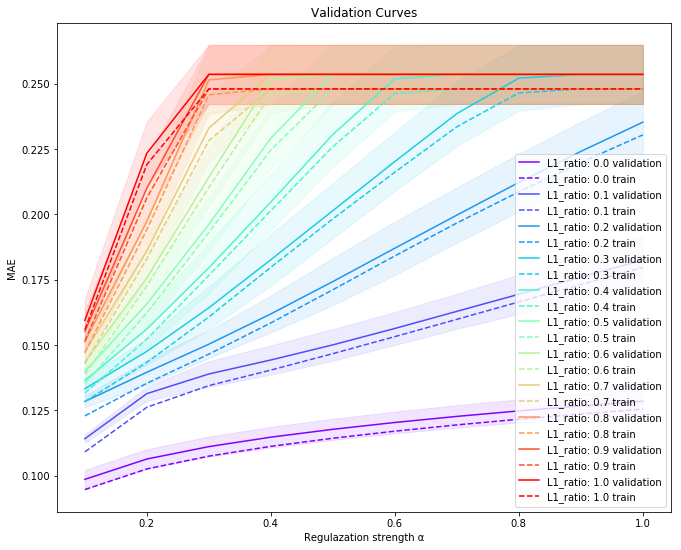

In [48]:
colors = iter(plt.cm.rainbow(np.linspace(0, 1, scores_by_L1_ratio.ngroups)))
fig = plt.subplots(figsize=(11, 9))
for ind in list(scores_by_L1_ratio.groups.keys()):
    color = next(colors)
    std_plus =  scores_by_L1_ratio.get_group(ind).MAE_test + scores_by_L1_ratio.get_group(ind).std_test_score
    std_minus = scores_by_L1_ratio.get_group(ind).MAE_test - scores_by_L1_ratio.get_group(ind).std_test_score
    plt.plot(scores_by_L1_ratio.get_group(ind).alpha, scores_by_L1_ratio.get_group(ind).MAE_test, label = 'L1_ratio: {:.1f} validation'.format(ind), color = color)
    plt.plot(scores_by_L1_ratio.get_group(ind).alpha, scores_by_L1_ratio.get_group(ind).MAE_train, label = 'L1_ratio: {:.1f} train'.format(ind), color = color, linestyle="--")
    plt.fill_between(np.array(scores_by_L1_ratio.get_group(ind).alpha, dtype = float), std_minus, std_plus, alpha=0.1, color = color)
    plt.title('Validation Curves')
    plt.xlabel('Regulazation strength α')
    plt.ylabel('MAE')
    plt.legend()
plt.show()



I observe tha the lowest MAE error when alpha = 0.1 and L1 ratio = 0, which corresponds to the corner case of only L2 regularization (and not LASSO regularization (Least Absolute Shrinkage and Selection operator)).

### Making predictions

I will make predictions fot the best fit which led to the minimum mean absolute error.

In [50]:
# predict
y_test_pred_qt = grid_cv.best_estimator_.predict(X_test)
# invert the quantile transformation
y_test_pred = qt.inverse_transform(y_test_pred_qt.reshape(-1, 1))[:,0]

In [51]:
ElasticNet_mae = MAE(y_test, y_test_pred)

In [52]:
ElasticNet_mae

38.78341843986247

In [53]:
RSSmodel = RSS(y_test, y_test_pred)
#print('R2: {:.3f}'.format(R2))
RSSbaseline = RSS(y_test, y_tr_valid.mean()) 
R2 = 1-(RSSmodel/RSSbaseline)
print('R2: {:.3f}'.format(R2))

R2: 0.316


In [54]:
r2 = R2_score(y_test, y_test_pred, y_tr_valid)
r2

0.3159569389970738

In [55]:
results_elastic = {'model': ['ElasticNet'], 'r2_score': r2, 'MAE': ElasticNet_mae}
results_elastic = pd.DataFrame(results_elastic)
np.save('results_ElasticNet', results_elastic)
results_elastic

,model,r2_score,MAE
0,ElasticNet,0.315957,38.783418


### Ploting the predictions along with the real values

In [56]:
y_test_df = pd.read_pickle('y_te.csv')
y_test_df = pd.DataFrame(y_test_df)
y_test_df['PM2.5 - prediction'] = y_test_pred
y_test_df['Residuals'] = y_test - y_test_pred
y_test_df.head()

,PM2.5,PM2.5 - prediction,Residuals
Date and Time,,,
2016-09-01 00:00:00,12.0,17.0,-5.0
2016-09-01 01:00:00,17.0,15.0,2.0
2016-09-01 02:00:00,3.0,16.0,-13.0
2016-09-01 03:00:00,8.0,13.0,-5.0
2016-09-01 04:00:00,14.0,16.0,-2.0


I save the predictions of ElasticNet.

In [57]:
y_test_df.to_pickle('ElasticNet_predictions.csv')

In [58]:
y_test_df.index

DatetimeIndex(['2016-09-01 00:00:00', '2016-09-01 01:00:00',
               '2016-09-01 02:00:00', '2016-09-01 03:00:00',
               '2016-09-01 04:00:00', '2016-09-01 05:00:00',
               '2016-09-01 06:00:00', '2016-09-01 07:00:00',
               '2016-09-01 08:00:00', '2016-09-01 09:00:00',
               ...
               '2017-02-28 14:00:00', '2017-02-28 15:00:00',
               '2017-02-28 16:00:00', '2017-02-28 17:00:00',
               '2017-02-28 18:00:00', '2017-02-28 19:00:00',
               '2017-02-28 20:00:00', '2017-02-28 21:00:00',
               '2017-02-28 22:00:00', '2017-02-28 23:00:00'],
              dtype='datetime64[ns]', name='Date and Time', length=4344, freq=None)

In [59]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

I save the results

In [61]:
font_dict = {'fontname':'Arial', 'size':'16'}

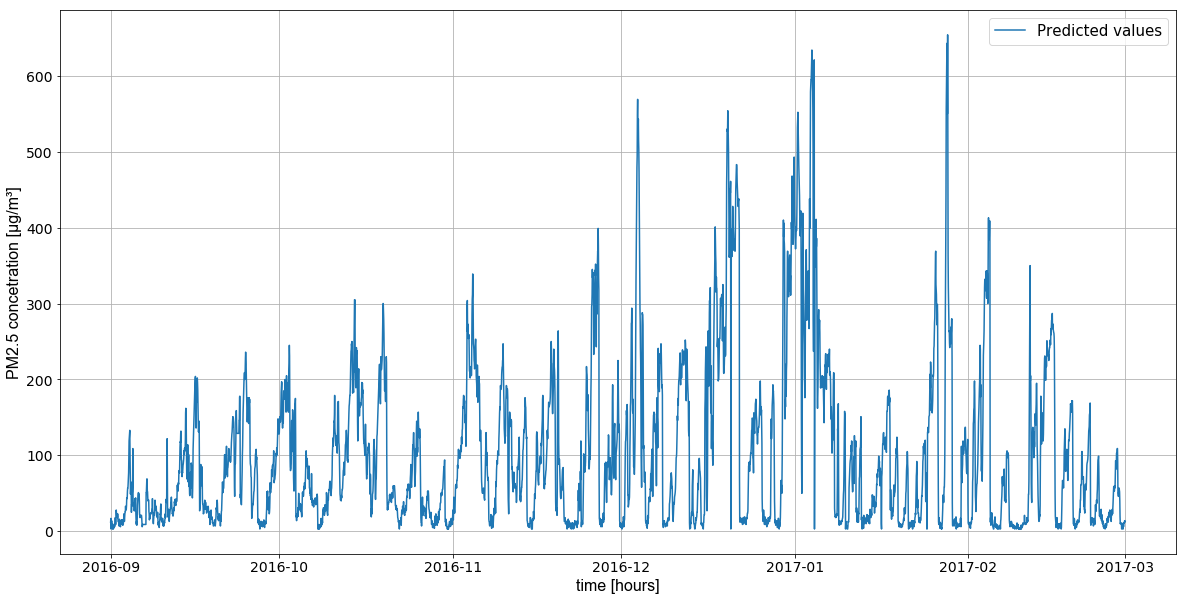

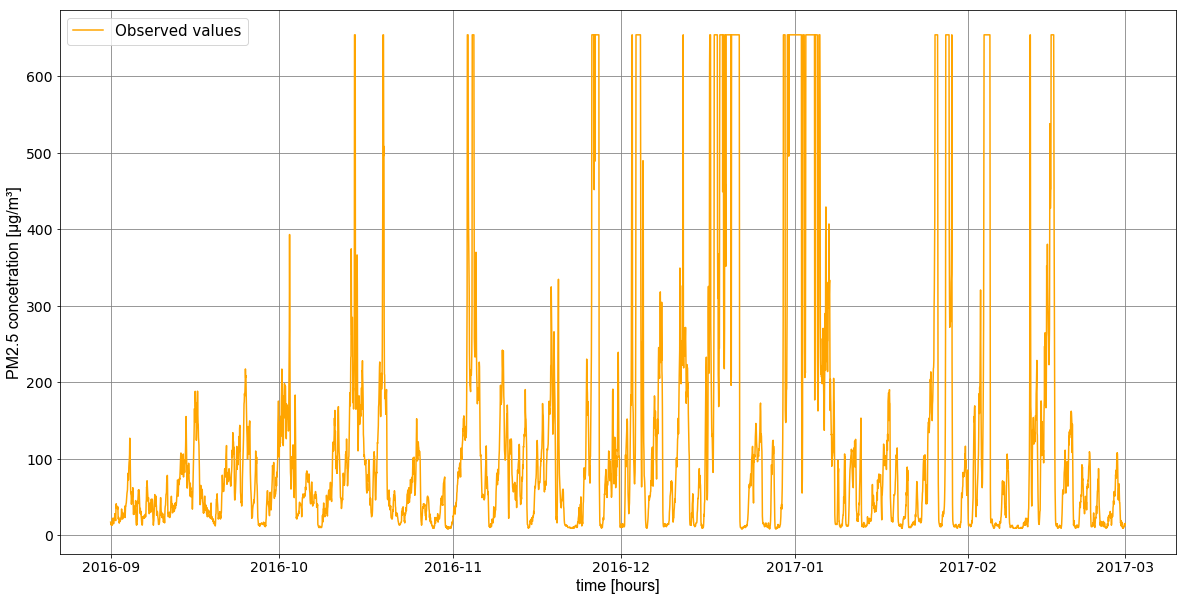

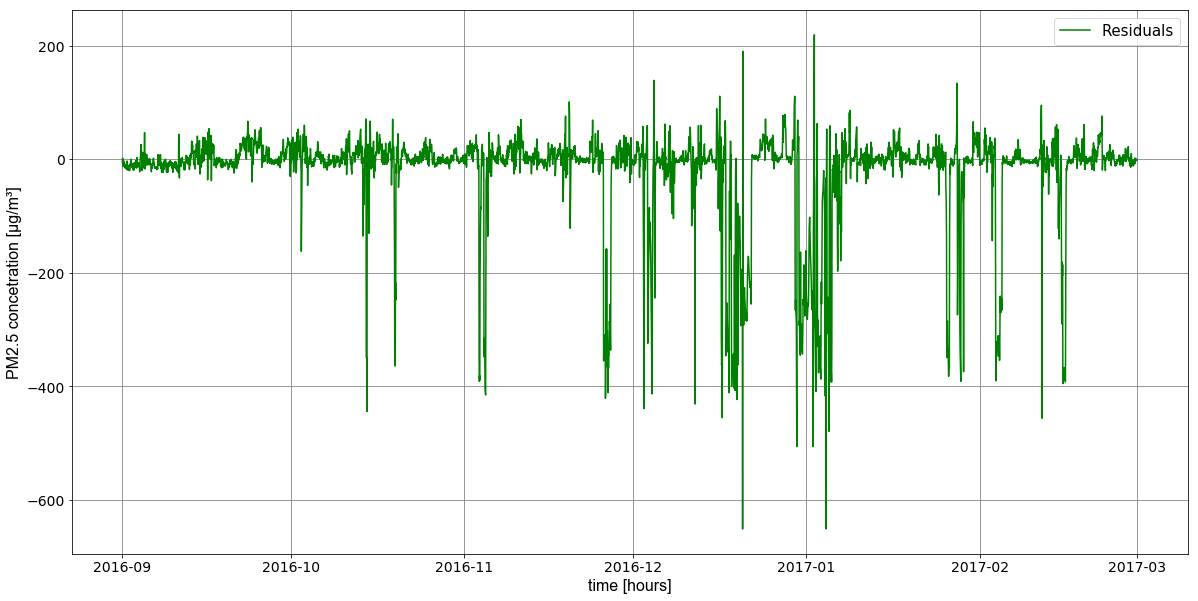

In [66]:
# plot Observations
plt.figure(figsize = (20,10))
plt.plot(y_test_df['PM2.5'], label = 'Predicted values')
plt.ylabel('PM2.5 concetration [µg/m³]', fontdict = font_dict)
plt.xlabel('time [hours]', fontdict = font_dict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={"size":15})
plt.grid(True)
plt.rc('grid', linestyle='-', color='grey')
plt.show()
# plot Predictions
plt.figure(figsize = (20,10))
plt.plot(y_test_df['PM2.5 - prediction'], color = 'orange', label = 'Observed values')
plt.ylabel('PM2.5 concetration [µg/m³]', fontdict = font_dict)
plt.xlabel('time [hours]', fontdict = font_dict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={"size":15})
plt.grid(True)
plt.rc('grid', linestyle='-', color='grey')
plt.show()
# plot Residuals
plt.figure(figsize = (20,10))
plt.plot(y_test_df['Residuals'], color = 'green', label = 'Residuals')
plt.ylabel('PM2.5 concetration [µg/m³]', fontdict = font_dict)
plt.xlabel('time [hours]', fontdict = font_dict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={"size":15})
plt.grid(True)
plt.rc('grid', linestyle='-', color='grey')
plt.show()

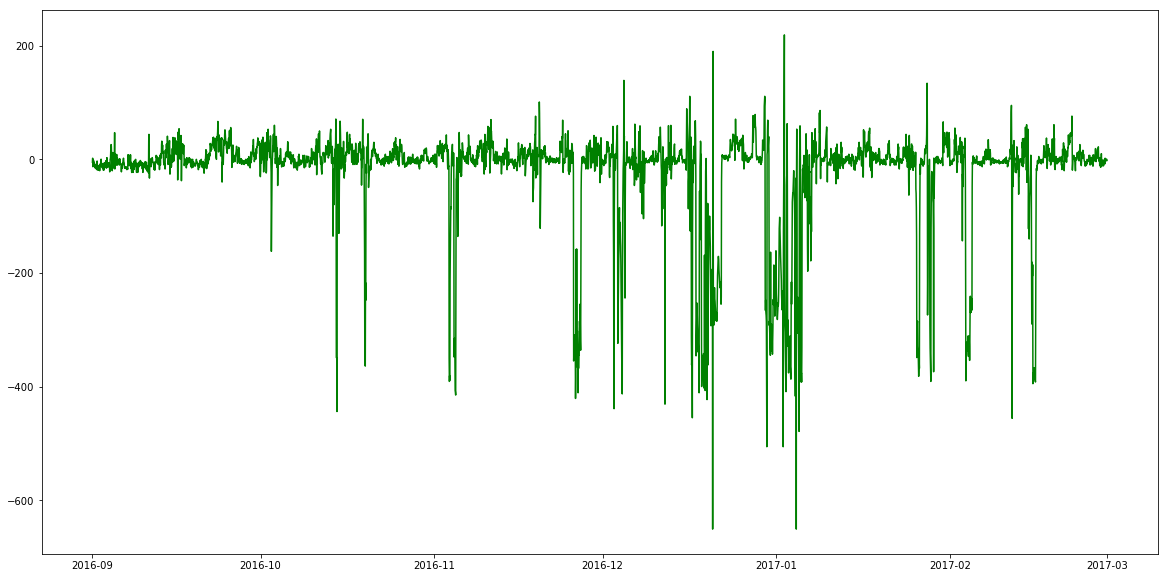

In [67]:
# plot Residuals
plt.figure(figsize = (20,10))
plt.plot(y_test_df['Residuals'], color = 'green')
plt.show()

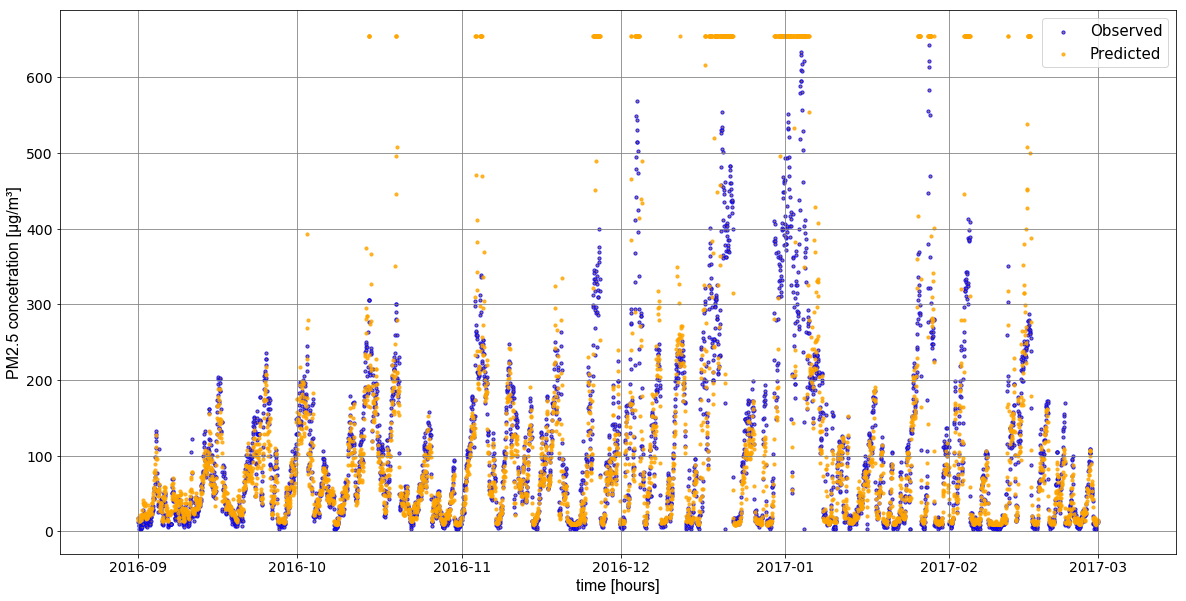

In [68]:
plt.figure(figsize = (20,10))
plt.scatter(y_test_df.index, y_test_df['PM2.5'], color = 'blue',  s=10, facecolors='C5', edgecolors='b', alpha = 0.8, label = 'Observed')
plt.scatter(y_test_df.index, y_test_df['PM2.5 - prediction'], color = 'orange', s=10, facecolors='orange', edgecolors='orange', alpha = 0.8, label = 'Predicted')
plt.ylabel('PM2.5 concetration [µg/m³]', fontdict = font_dict)
plt.xlabel('time [hours]', fontdict = font_dict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={"size":15})
plt.grid(True)
plt.rc('grid', linestyle='-', color='grey')
plt.show()

for better readability I will plot the prediction for one month.

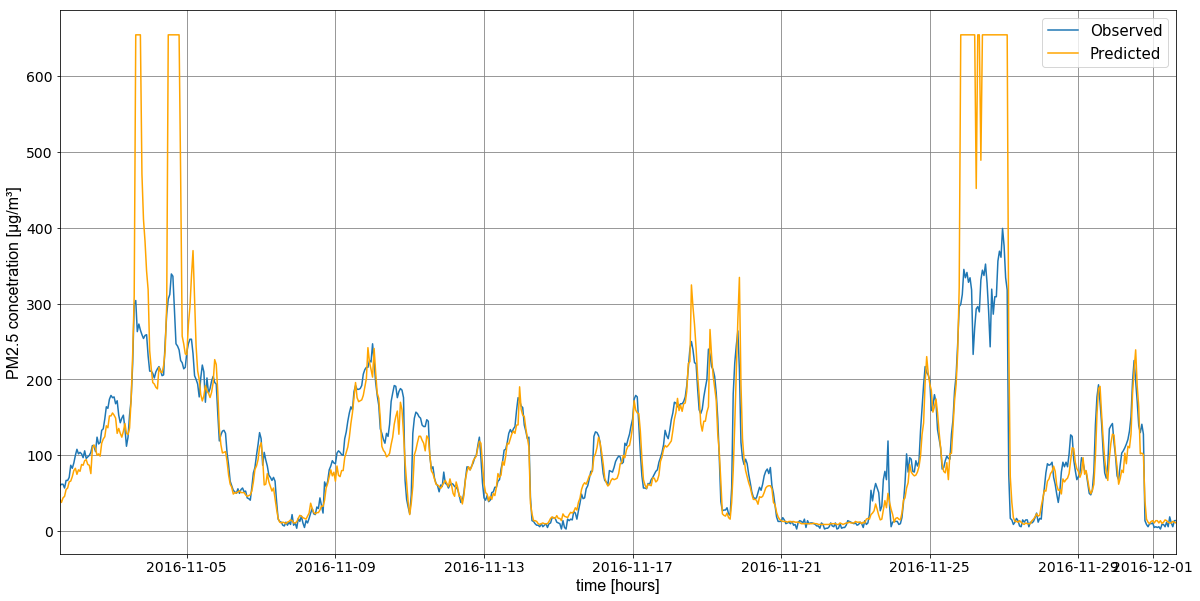

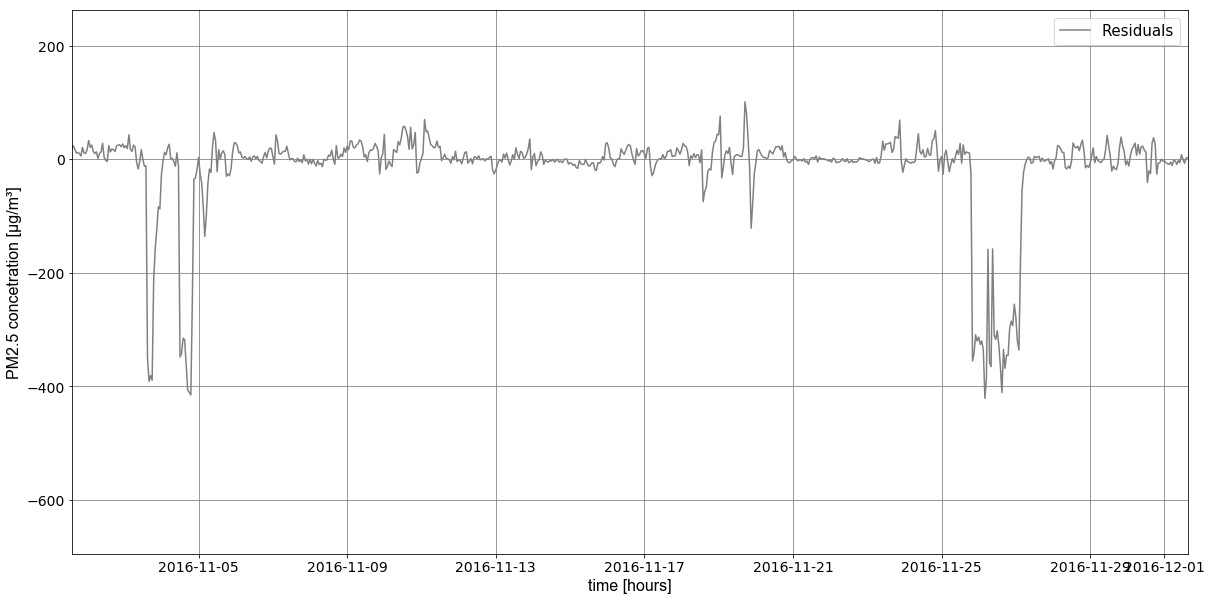

In [69]:
# plot Observations
plt.figure(figsize = (20,10))
plt.plot(y_test_df['PM2.5'], label = 'Observed')

# plot Predictions
plt.plot(y_test_df['PM2.5 - prediction'], color = 'orange', label = 'Predicted')
plt.xlim( '2016-11-1 14:00:00', '2016-12-1 15:00:00')
plt.ylabel('PM2.5 concetration [µg/m³]', fontdict = font_dict)
plt.xlabel('time [hours]', fontdict = font_dict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={"size":15})
plt.grid(True)
plt.rc('grid', linestyle='-', color='grey')
plt.show()

# plot Residuals
plt.figure(figsize = (20,10))
plt.plot(y_test_df['Residuals'], color = 'grey')
plt.xlim( '2016-11-1 14:00:00', '2016-12-1 15:00:00')
plt.ylabel('PM2.5 concetration [µg/m³]', fontdict = font_dict)
plt.xlabel('time [hours]', fontdict = font_dict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={"size":15})
plt.grid(True)
plt.rc('grid', linestyle='-', color='grey')
plt.show()

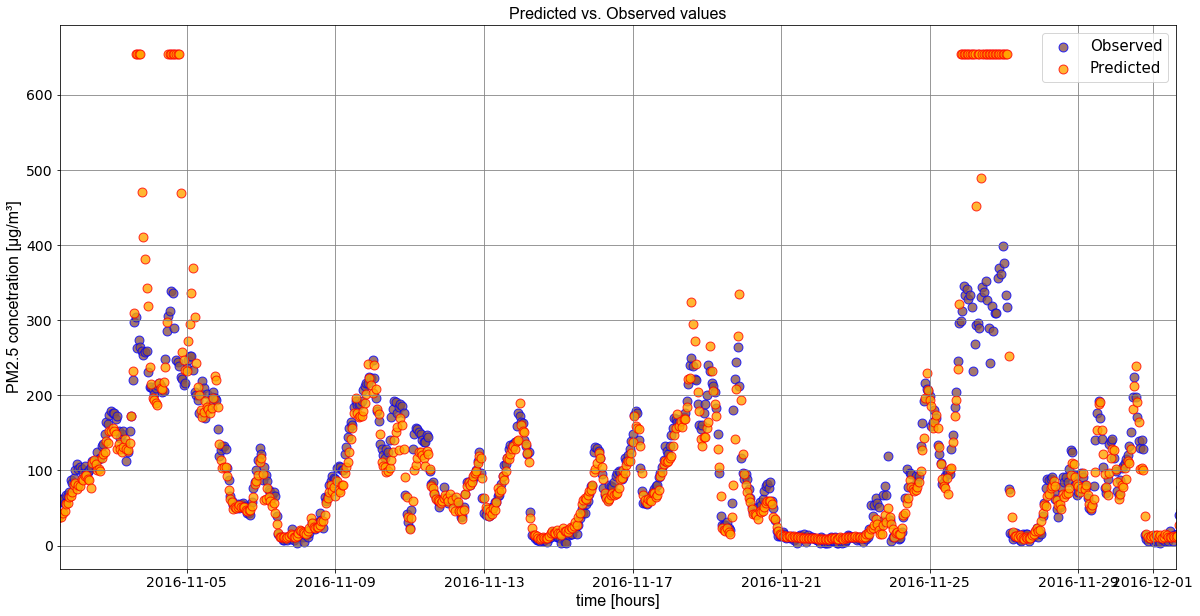

In [70]:
plt.figure(figsize = (20,10))
plt.scatter(y_test_df.index, y_test_df['PM2.5'], color = 'blue',  s=80, facecolors='C5', edgecolors='b', alpha = 0.8, label = 'Observed')
plt.scatter(y_test_df.index, y_test_df['PM2.5 - prediction'], color = 'orange', s=80, facecolors='orange', edgecolors='r', alpha = 0.8, label = 'Predicted')
plt.xlim( '2016-11-1 14:00:00', '2016-12-1 15:00:00')
plt.title('Predicted vs. Observed values', fontdict = font_dict)
plt.ylabel('PM2.5 concetration [µg/m³]', fontdict = font_dict)
plt.xlabel('time [hours]', fontdict = font_dict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={"size":15})
plt.grid(True)
plt.rc('grid', linestyle='-', color='grey')
plt.show()

I observe that the Elastic Net model does not predict the high concentration values very well, while it works quite well for the low concentration values of PM2.5.